In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from collections import Counter
from string import punctuation

from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
#nltk.download('punkt')

In [2]:
file = open('photo.json', 'r')

In [3]:
stop = 200000
all_data = []

for i, line in enumerate(file):
    if i%200000 == 0:
        print(i)
    if i == stop:
        break
    
    data = json.loads(line)
    
    photo_id = data['photo_id']
    business_id = data['business_id']
    caption = data['caption']
    label = data['label']
    
    all_data.append([photo_id
                     , business_id
                     , caption
                     , label])
    
df = pd.DataFrame(all_data, columns = ['photo_id'
                                       , 'business_id'
                                       , 'caption'
                                       , 'label'])

file.close()

0


In [4]:
df.head()

,photo_id,business_id,caption,label
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside
1,YjxBE88Bf6CmTEF2LP1UNA,Kn23LDd740SBVJ7mum0fwg,,inside
2,1f7izSjM0WjkDRIVbPy1yw,ZkGDCVKSdf8m76cnnalL-A,,food
3,NcSlcDTEEeOaixotOPk-rA,bF8gv7k_rwZtiDLP2ZB04w,,inside
4,5IiIo5UKEW0lWqZ6sWrY_A,50Anorn0DJXFhBr9a9_gHQ,,inside


In [5]:
df.label.value_counts()

food       114874
inside      52448
drink       18121
outside     11534
menu         3023
Name: label, dtype: int64

In [6]:
df['photo_path'] = '/home/david/Downloads/photos/'+ df.photo_id + '.jpg'

In [7]:
df.head(1)

,photo_id,business_id,caption,label,photo_path
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside,/home/david/Downloads/photos/MllA1nNpcp1kDteVg...


In [8]:
classes_ctn = pd.DataFrame(df.label.value_counts())
classes_ctn

,label
food,114874
inside,52448
drink,18121
outside,11534
menu,3023


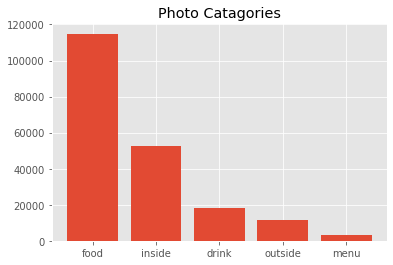

In [9]:
plt.bar(classes_ctn.index, classes_ctn.label)
plt.title('Photo Catagories')
plt.savefig('photo_cat_ctn.png');

In [10]:
df_short_balanced = df.groupby('label').apply(lambda x: x.sample(n=3023)).reset_index(drop=True)

In [11]:
df_short_balanced.label.value_counts()

outside    3023
food       3023
inside     3023
drink      3023
menu       3023
Name: label, dtype: int64

In [12]:
df_short_balanced.shape

(15115, 5)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [14]:
print(os.getcwd())

/home/david/image_help_from_yelp


In [15]:
print(os.listdir())

['top_50_stemming_words.png', 'NB_roc_curve_lem.png', 'README.md', 'SGD_roc_curve.png', 'yelp_lem_wc.png', 'photo.json', 'AdaBoost_roc_curve_lem.png', 'top_50_lemmatized_words.png', 'SGD_roc_curve_lem.png', 'MLP_roc_curve.png', 'yelp_stem_wc.png', 'photos_eda.ipynb', 'NB_roc_curve.png', 'AdaBoost_roc_curve.png', 'photo_cat_ctn.png', '.git', '.ipynb_checkpoints']


In [16]:
img = cv2.imread('/home/david/Downloads/photos/'+ df.photo_id.iloc[0] + '.jpg'
                 , 0) #1 is color, 0, is grayscale, -1 is alpha channel


In [17]:
print(img)

[[  0  43   8 ...  11  32   0]
 [ 34 150 158 ... 142 115  19]
 [  8 176 200 ... 171 172  29]
 ...
 [ 11  15  15 ...  18  17   4]
 [ 17  17  22 ...  10  13   4]
 [  3   9  14 ...   4  10   2]]


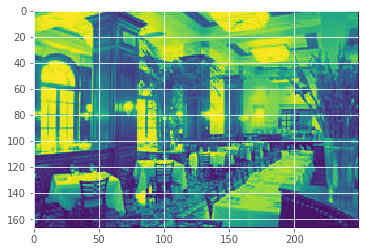

In [18]:
plt.imshow(img);

Reference: https://github.com/netik1020/Concise-iPython-Notebooks-for-Deep-learning/blob/master/Image_Classifier/skin_cancer_classification_1.ipynb

In [20]:
df_short_balanced.head(1)

,photo_id,business_id,caption,label,photo_path
0,Dx3AhOjXdWfQVJ-f4NjDJQ,uXZ4Of7CV77SmKIjya3y_A,Rum Punch at the Varsity,drink,/home/david/Downloads/photos/Dx3AhOjXdWfQVJ-f4...


In [21]:
X = np.array([cv2.imread(df_short_balanced.photo_path.iloc[x]) for x in range(len(df_short_balanced))])

In [22]:
y = np.array([df_short_balanced.label.iloc[x] for x in range(len(df_short_balanced))])

In [23]:
X.shape

(15115,)

In [24]:
y.shape

(15115,)

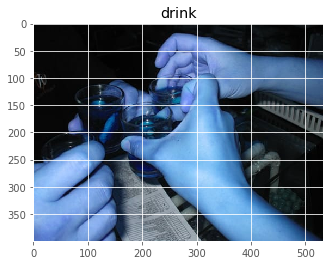

In [25]:
plt.imshow(X[1115])
plt.title(y[1115]);